lstm_staeful.py from the Official Keras examples

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Activation
#from keras.layers import Dense, LSTM, GRU
from keras.models import load_model
from keras.optimizers import RMSprop
import scipy.io as sio
%matplotlib inline

Using TensorFlow backend.
/Users/davidgroppe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/davidgroppe/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
x=np.arange(10)
y_eeg=x+10
y_art=x+30
print(x)
print(y_eeg)
print(y_art)

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[30 31 32 33 34 35 36 37 38 39]


In [5]:
def get_all_data(x,y_eeg,y_art,n_wind):
    temp_n_tpt=len(x)
    n_clip_tpt=temp_n_tpt-n_wind
    x_clip=np.zeros((n_clip_tpt,n_wind,1))
    y_clip=np.zeros((n_clip_tpt,2))
    for ct in range(0,n_clip_tpt):
        x_clip[ct,:,0]=x[ct:ct+n_wind]
        y_clip[ct,0]=y_eeg[ct+int(np.floor(n_wind/2))] # Target output is the value of the clean and artifact data at
        # the center time point
        y_clip[ct,1]=y_art[ct+int(np.floor(n_wind/2))]
        #x_clip[ct,:,0]=x[0,cursor:cursor+n_wind]
        #y_clip[ct,0]=y[0,cursor+int(np.floor(n_wind/2))]
    x_clip=np.flip(x_clip,1) #TODO do this once to the data to speed up clip generation
    return x_clip, y_clip
                
n_wind=3
x_clip, y_clip=get_all_data(x,y_eeg,y_art,n_wind)

In [8]:
print(np.squeeze(x_clip))
print(np.squeeze(y_clip))

[[2. 1. 0.]
 [3. 2. 1.]
 [4. 3. 2.]
 [5. 4. 3.]
 [6. 5. 4.]
 [7. 6. 5.]
 [8. 7. 6.]]
[[11. 31.]
 [12. 32.]
 [13. 33.]
 [14. 34.]
 [15. 35.]
 [16. 36.]
 [17. 37.]]


In [2]:
# Load data and split it into train, valid, & test
in_fname='SAMPLE_DATA/clean_data_py_format.mat'
mat=sio.loadmat(in_fname)
print(mat.keys())
print(mat['use_chans'][0,4][:])
eeg=mat['data'][4,:] # Channel Fz
print(eeg.shape)
n_tpt=len(eeg)
eeg=(eeg-np.mean(eeg))/(2*np.std(eeg))
print(n_tpt)
#scale some more
eeg=eeg*.3
art=art*.7

dict_keys(['__header__', 'use_chans', 'data', '__globals__', '__version__', 'srate'])
['Fz']
(30504,)
30504


NameError: name 'art' is not defined

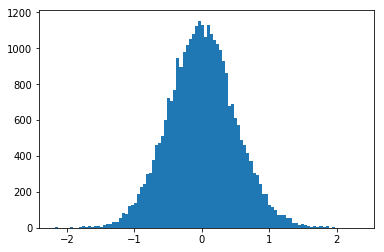

In [30]:
plt.figure(1)
plt.hist(eeg,100);

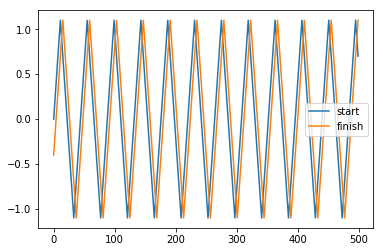

In [21]:
# Create simulated artifact
art=np.zeros(eeg.shape)
delt=.1
for t in range(1,n_tpt):
    if (art[t-1]>=1) or (art[t-1]<=-1):
        delt=-delt
    art[t]=art[t-1]+delt
    
plt.figure(1)
plt.clf()
plt.plot(art[:500],label='start')
plt.plot(art[-500:],label='finish')
plt.legend()

Text(0.5,1,'Clean EEG')

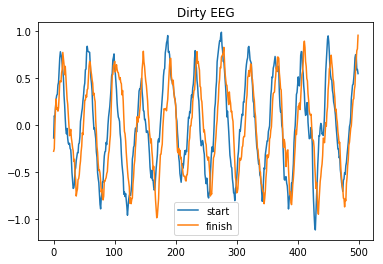

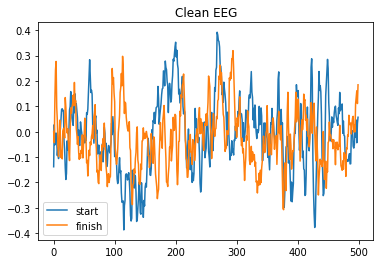

In [109]:
dirty_eeg=eeg+art;
plt.figure(2)
plt.clf()
plt.plot(dirty_eeg[:500],label='start')
plt.plot(dirty_eeg[-500:],label='finish')
plt.legend()
plt.title('Dirty EEG')

plt.figure(3)
plt.clf()
plt.plot(eeg[:500],label='start')
plt.plot(eeg[-500:],label='finish')
plt.legend()
plt.title('Clean EEG')

In [41]:
# Split Data into Train, Valid, & Test
n_train_tpt=int(np.floor(n_tpt*.5))
n_valid_tpt=int(np.floor(n_tpt*.25))
n_test_tpt=n_tpt-n_valid_tpt-n_train_tpt
print('%d training tpts, %f of data' % (n_train_tpt, n_train_tpt/n_tpt))
print('%d validation tpts, %f of data' % (n_valid_tpt, n_valid_tpt/n_tpt))
print('%d test tpts, %f of data' % (n_test_tpt, n_test_tpt/n_tpt))

train_ids=(0,n_train_tpt)
valid_ids=(n_train_tpt,n_train_tpt+n_valid_tpt)
test_ids=(n_train_tpt+n_valid_tpt,n_train_tpt+n_valid_tpt+n_test_tpt)

15252 training tpts, 0.500000 of data
7626 validation tpts, 0.250000 of data
7626 test tpts, 0.250000 of data


In [88]:
def get_data_clip(x,y_eeg,y_art,id_range,n_clip_tpt,n_wind):
    temp_n_tpt=len(x)
    print(temp_n_tpt) #TODO remove
    x_clip=np.zeros((n_clip_tpt,n_wind,1))
    y_clip=np.zeros((n_clip_tpt,2))
    start_id=np.random.randint(id_range[0],id_range[1]-n_clip_tpt-n_wind)
    #start_id=np.random.randint(0,temp_n_tpt-n_clip_tpt)
    #start_id=0
    print('start_id: {}'.format(start_id))
    for ct, cursor in enumerate(range(start_id,start_id+n_clip_tpt)):
        x_clip[ct,:,0]=x[cursor:cursor+n_wind]
        y_clip[ct,0]=y_eeg[cursor+int(np.floor(n_wind/2))] # Target output is the value of the clean and artifact data at 
        # the center time point TODO add second output 
        y_clip[ct,1]=y_art[cursor+int(np.floor(n_wind/2))]
        #x_clip[ct,:,0]=x[0,cursor:cursor+n_wind]
        #y_clip[ct,0]=y[0,cursor+int(np.floor(n_wind/2))]
    x_clip=np.flip(x_clip,1) #TODO do this once to the data to speed up clip generation
    return x_clip, y_clip

In [45]:
print(train_ids)

(0, 15252)


In [47]:
n_clip_tpt=10
n_wind=3
x_clip, y_clip=get_data_clip(dirty_eeg,art,train_ids,n_clip_tpt,n_wind)
print(x_clip.shape)
print(y_clip.shape)
print(np.squeeze(x_clip[0:3,:]))
print(np.squeeze(y_clip[0:3]))
print()
print(dirty_eeg[0:4])
print(art[0:4])

30504
start_id: 0
(10, 3, 1)
(10, 1)
[[-0.03387068  0.16213381 -0.46090004]
 [ 0.13323896 -0.03387068  0.16213381]
 [ 0.26203222  0.13323896 -0.03387068]]
[0.1 0.2 0.3]

[-0.46090004  0.16213381 -0.03387068  0.13323896]
[0.  0.1 0.2 0.3]


In [136]:
# Function for creating model
def create_model(stateful,n_wind,batch_size):
    model = Sequential()
    n_hidden=240
    model.add(GRU(n_hidden,
              #input_shape=(lahead, 1),
              input_shape=(n_wind, 1),
              batch_size=batch_size,
              stateful=stateful))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    #model.compile(loss='mse', optimizer='adam')
    rmsp = RMSprop(lr=0.00001)
    model.compile(loss='mse', optimizer=rmsp)
    #model.compile(loss='mse', optimizer='rmsprop',lr=0.00001)
    model.summary()
    return model

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_train_clip.shape)
print(y_train_clip.shape)
print(x_valid_clip.shape)
print(y_valid_clip.shape)

(49999,)
(49999,)
(800, 3, 1)
(800, 1)
(200, 3, 1)
(200, 1)


In [137]:
print('Creating Stateful Model...')
batch_size = 1
n_wind=7
epochs = 25
stateful=True
model_stateful = create_model(stateful,n_wind,batch_size)
model_fname='temp_stateful.h5'

val_loss=list()
train_loss=list()
patience=3

# val_loss=np.zeros(epochs)
# train_loss=np.zeros(epochs)
print('Training')
n_last_improvement=0
best_val_loss=np.nan
for i in range(epochs):
    print('Epoch', i + 1, '/', epochs)
    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in data_input.
    # Each of these series are offset by one step and can be
    # extracted with data_input[i::batch_size].
    n_clip_tpt=1000
    #x_train_clip, y_train_clip=get_data_clip(x_train,y_train,n_clip_tpt,n_wind)
    x_train_clip, y_train_clip=get_data_clip(dirty_eeg,art,eeg,train_ids,n_clip_tpt,n_wind)
    n_clip_tpt=800
    #x_valid_clip, y_valid_clip=get_data_clip(x_valid,y_valid,n_clip_tpt,n_wind)
    x_valid_clip, y_valid_clip=get_data_clip(dirty_eeg,art,eeg,valid_ids,n_clip_tpt,n_wind)
    train_hist_stateful=model_stateful.fit(x_train_clip,
                       y_train_clip,
                       batch_size=batch_size,
                       epochs=1,
                       verbose=1,
                       validation_data=(x_valid_clip, y_valid_clip),
                       shuffle=False)
    val_loss.append(train_hist_stateful.history['val_loss'][0])
    train_loss.append(train_hist_stateful.history['loss'][0])
    if np.isnan(best_val_loss) or best_val_loss>val_loss[-1]:
        # first epoch or improved performance
        best_val_loss=val_loss[-1]
        n_last_improvement=0
        print('Best validation loss so far. Saving model as %s' % model_fname)
        model_stateful.save(model_fname)
    else:
        # No improvment
        n_last_improvement+=1
    if n_last_improvement>=patience:
        print('Validation loss not improving. EXITING!')
        break
        
    
    #val_loss[i]=train_hist_stateful.history['val_loss'][0]
    #train_loss[i]=train_hist_stateful.history['loss'][0]
    model_stateful.reset_states()

Creating Stateful Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (1, 240)                  174240    
_________________________________________________________________
dropout_10 (Dropout)         (1, 240)                  0         
_________________________________________________________________
dense_16 (Dense)             (1, 2)                    482       
Total params: 174,722.0
Trainable params: 174,722.0
Non-trainable params: 0.0
_________________________________________________________________
Training
Epoch 1 / 25
30504
start_id: 9560
30504
start_id: 15770
Train on 1000 samples, validate on 800 samples
Epoch 1/1
1000/1000 [==============================] - 10s - loss: 0.0682 - val_loss: 0.0277
Best validation loss so far. Saving model as temp_stateful.h5
Epoch 2 / 25
30504
start_id: 9856
30504
start_id: 21036
Train on 1000 samples, validate on 800 sampl

Best valid loss 0.01442021165420897


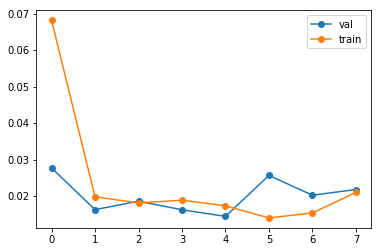

In [139]:
plt.figure(1)
plt.clf()
plt.plot(np.asarray(val_loss),'-o',label='val')
plt.plot(np.asarray(train_loss),'-o',label='train')
plt.legend()
print('Best valid loss {}'.format(np.min(val_loss)))

In [140]:
print('Loading best model: %s' % model_fname)
model_stateful=load_model(model_fname)

n_clip_tpt=1000
x_test_clip, y_test_clip=get_data_clip(dirty_eeg,art,eeg,test_ids,n_clip_tpt,n_wind)

print('Predicting')
predicted_stateful = model_stateful.predict(x_test_clip, batch_size=batch_size)
print('Done')

Loading best model: temp_stateful.h5
30504
start_id: 23272
Predicting
Done


Plotting Results


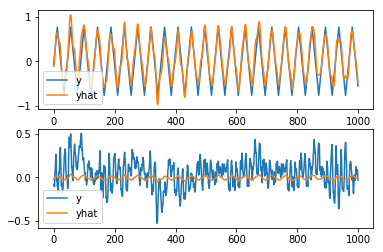

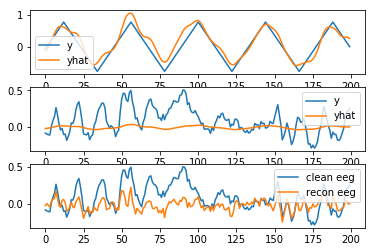

In [143]:
print('Plotting Results')
plt.figure(1)
plt.clf()
for a in range(2):
    plt.subplot(2,1,a+1)
    plt.plot(y_test_clip[:,a],label='y')
    plt.plot(predicted_stateful[:,a],label='yhat')
    plt.legend()

temp_dirty_eeg=np.zeros(x_test_clip.shape[0])
for a in range(len(temp_dirty_eeg)):
    temp_dirty_eeg[a]=x_test_clip[a,3,0]

n_show=200
plt.figure(2)
plt.clf()
for a in range(2):
    plt.subplot(3,1,a+1)
    plt.plot(y_test_clip[:n_show,a],label='y')
    plt.plot(predicted_stateful[:n_show,a],label='yhat')
    plt.legend()
plt.subplot(3,1,3)
plt.plot(y_test_clip[:n_show,1],label='clean eeg')
plt.plot(temp_dirty_eeg[:n_show]-predicted_stateful[:n_show,0],label='recon eeg')
plt.legend()
